In [1]:
!pip install tensorflow_addons

In [2]:
from kaggle_datasets import KaggleDatasets

In [3]:
from tensorflow.keras import Model, layers, activations
import tensorflow_addons as tfa
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

2022-04-24 20:53:27.104378: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-24 20:53:27.104460: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Set up the TPU

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Running on TPU",tpu.master())
except:
    tpu=None
    print("Nope")
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("Replicas",strategy.num_replicas_in_sync)

2022-04-24 20:53:29.009084: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-24 20:53:29.009398: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-24 20:53:29.009421: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-24 20:53:29.009444: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f9352ef3fac8): /proc/driver/nvidia/version does not exist
2022-04-24 20:53:29.010186: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Running on TPU grpc://10.0.0.2:8470


2022-04-24 20:53:34.637560: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-04-24 20:53:34.637619: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30042}
2022-04-24 20:53:34.639255: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-04-24 20:53:34.639312: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30042}


Replicas 8


# Defining Model

In [5]:
from tensorflow.keras import Model, layers, activations
import tensorflow_addons as tfa
import math

def round_filters(filters, multiplier=1.):
    divisor = 8
    min_depth = 8
    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    return int(new_filters)


def round_repeats(repeats, multiplier=1.):
    return int(math.ceil(multiplier * repeats))


def squeeze_and_excite(x, in_channels, out_channels, activation, reduction_ratio=4):
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(in_channels // reduction_ratio)(x)
    x = layers.Activation(activation)(x)
    x = layers.Dense(out_channels)(x)
    x = layers.Activation(activations.sigmoid)(x)
    return x


def fused_mbconv(x, in_channels, out_channels, kernel_size, activation, stride=1, reduction_ratio=4,
                 expansion=6, dropout=None, drop_connect=.2):
    shortcut = x
    expanded = round_filters(in_channels * expansion)
    if expansion != 1:
        x = layers.Conv2D(expanded, kernel_size, stride, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization(epsilon=1e-5)(x)
        x = layers.Activation(activation)(x)

        if (dropout is not None) and (dropout != 0.):
            x = layers.Dropout(dropout)(x)

    if reduction_ratio is not None:
        se = squeeze_and_excite(x, in_channels, expanded, activation, reduction_ratio)
        x = layers.Multiply()([x, se])

    x = layers.Conv2D(out_channels, (1, 1) if expansion != 1 else kernel_size, 1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    if expansion == 1:
        x = layers.Activation(activation)(x)
    if (stride == 1) and (in_channels == out_channels):
        x = tfa.layers.StochasticDepth(1 - drop_connect)([shortcut, x])
    return x


def mbconv(x, in_channels, out_channels, kernel_size, activation, stride=1,
           reduction_ratio=4, expansion=6, dropout=None, drop_connect=.2):
    shortcut = x
    expanded = round_filters(in_channels * expansion)
    if expansion != 1:
        x = layers.Conv2D(expanded, (1, 1), 1, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization(epsilon=1e-5)(x)
        x = layers.Activation(activation)(x)

    x = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.Activation(activation)(x)

    if (expansion != 1) and (dropout is not None) and (dropout != 0.):
        x = layers.Dropout(dropout)(x)

    if reduction_ratio is not None:
        se = squeeze_and_excite(x, in_channels, expanded, activation, reduction_ratio)
        x = layers.Multiply()([x, se])

    x = layers.Conv2D(out_channels, (1, 1), 1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    if (stride == 1) and (in_channels == out_channels):
        x = tfa.layers.StochasticDepth(1 - drop_connect)([shortcut, x])
    return x


def repeat(x, count, in_channels, out_channels, kernel_size, activation,
           stride=1, reduction_ratio=None, expansion=6, fused=False, dropout=None, drop_connect=.2):
    for i in range(count):
        if fused:
            x = fused_mbconv(x, in_channels, out_channels, kernel_size,
                             activation, stride, reduction_ratio, expansion, dropout, drop_connect)
        else:
            x = mbconv(x, in_channels, out_channels, kernel_size, activation, stride,
                       reduction_ratio, expansion, dropout, drop_connect)
    return x


def stage(x, count, in_channels, out_channels, kernel_size, activation,
          stride=1, reduction_ratio=None, expansion=6, fused=False, dropout=None, drop_connect=.2):
    x = repeat(x, count=1, in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
               activation=activation, stride=stride, reduction_ratio=reduction_ratio,
               expansion=expansion, fused=fused, dropout=dropout, drop_connect=drop_connect)
    x = repeat(x, count=count - 1, in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
               activation=activation, stride=1, reduction_ratio=reduction_ratio,
               expansion=expansion, fused=fused, dropout=dropout, drop_connect=drop_connect)
    return x


def base(cfg, num_classes=5, input_tensor=None, activation=activations.swish,
         width_mult=1., depth_mult=1., conv_dropout_rate=None, dropout_rate=None, drop_connect=.2):
    inp = input_tensor
    # stage 0
    x = layers.Conv2D(cfg[0][4], kernel_size=(3, 3), strides=2, padding="same", use_bias=False)(inp)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.Activation(activation)(x)

    for stage_cfg in cfg:
        x = stage(x, count=round_repeats(stage_cfg[0], depth_mult),
                  in_channels=round_filters(stage_cfg[4], width_mult),
                  out_channels=round_filters(stage_cfg[5], width_mult),
                  kernel_size=stage_cfg[1], activation=activation, stride=stage_cfg[2],
                  reduction_ratio=stage_cfg[7], expansion=stage_cfg[3], fused=stage_cfg[6] == 1,
                  dropout=conv_dropout_rate, drop_connect=drop_connect)

    # final stage
    x = layers.Conv2D(round_filters(1280, width_mult), (1, 1), strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.Activation(activation)(x)

    x = layers.GlobalAvgPool2D()(x)
    if (dropout_rate is not None) and (dropout_rate != 0):
        x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(num_classes)(x)
    x = layers.Activation(activations.softmax)(x)

    return Model(inp, x)


def s(in_shape=(224, 224, 3), num_classes=7, input_tensor=None, activation=activations.swish,
      width_mult=1., depth_mult=1., conv_dropout_rate=None, dropout_rate=None, drop_connect=.2):
    # each row is a stage
    # count, kernel size, stride, expansion ratio, in channel, out channel, is fused(1 if true), reduction ratio(None if no se)
    cfg = [
        [2, 3, 1, 1, 24, 24, 1, None],
        [4, 3, 2, 4, 24, 48, 1, None],
        [4, 3, 2, 4, 48, 64, 1, None],
        [6, 3, 2, 4, 64, 128, 0, 4],
        [9, 3, 1, 6, 128, 160, 0, 4],
        [15, 3, 2, 6, 160, 256, 0, 4],
    ]
    input_tensor = layers.Input(in_shape) if input_tensor is None else input_tensor
    return base(cfg=cfg, num_classes=num_classes, input_tensor=input_tensor, activation=activation,
                width_mult=width_mult, depth_mult=depth_mult, conv_dropout_rate=conv_dropout_rate,
                dropout_rate=dropout_rate, drop_connect=drop_connect)

def xl(in_shape=(224, 224, 3), num_classes=4, input_tensor=None, activation=activations.swish,
      width_mult=1.0, depth_mult=1., conv_dropout_rate=None, dropout_rate=None, drop_connect=.2):
    cfg = [
        [4, 3, 1, 1, 32, 32, 1, None],
        [8, 3, 2, 4, 32, 64, 1, None],
        [8, 3, 2, 4, 64, 96, 1, None],
        [16, 3, 2, 4, 96, 192, 0, 4],
        [24, 3, 1, 6, 192, 256, 0, 4],
        [32, 3, 2, 6, 256, 512, 0, 4],
        [8, 3, 1, 6, 512, 640, 0, 4],
    ]
    input_tensor = layers.Input(in_shape) if input_tensor is None else input_tensor
    return base(cfg=cfg, num_classes=num_classes, input_tensor=input_tensor, activation=activation,
                width_mult=width_mult, depth_mult=depth_mult, conv_dropout_rate=conv_dropout_rate,
                dropout_rate=dropout_rate, drop_connect=drop_connect)

# Defining parameters

In [6]:
IMAGE_SIZE = [300, 300] 
EPOCHS = 40
BATCH_SIZE = 92
NUM_TRAINING_IMAGES = 10756
NUM_VAL_IMAGES = 3390
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VAL_STEPS = NUM_VAL_IMAGES // BATCH_SIZE
classes= ['Acne','AK','Melanoma','Psoriasis']

# Loading the Dataset

In [7]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

In [8]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tfrec4class')

In [9]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])# explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
    AUTO = tf.data.experimental.AUTOTUNE
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.prefetch(AUTO)
    dataset = dataset.map(read_labeled_tfrecord,num_parallel_calls=AUTO) # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    filenames = tf.io.gfile.glob(GCS_DS_PATH + '/Tfrec-aug-4class/train/*.tfrec')
    dataset = load_dataset(filenames, labeled=True, ordered=False)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(NUM_TRAINING_IMAGES)
    c=1
    plt.figure(figsize=(20, 4))
    for features in dataset.take(5):
        plt.subplot(1,5,c)
        plt.imshow(features[0].numpy())
        plt.title(classes[features[1].numpy()])
        c+=1
    plt.show()
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/Tfrec-aug-4class/val/*.tfrec'), labeled=True, ordered=False)
    dataset = dataset.shuffle(NUM_VAL_IMAGES)
    
    c=1
    plt.figure(figsize=(20, 4))
    for features in dataset.take(5):
        plt.subplot(1,5,c)
        plt.imshow(features[0].numpy())
        plt.title(classes[features[1].numpy()])
        c+=1
    plt.show()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    return dataset

def get_test_dataset(ordered=True):
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/Tfrec-aug-4class/test/*.tfrec'), labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

2022-04-24 20:53:46.953924: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 46, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1650833626.950618447","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 46, Output num: 1","grpc_status":3}


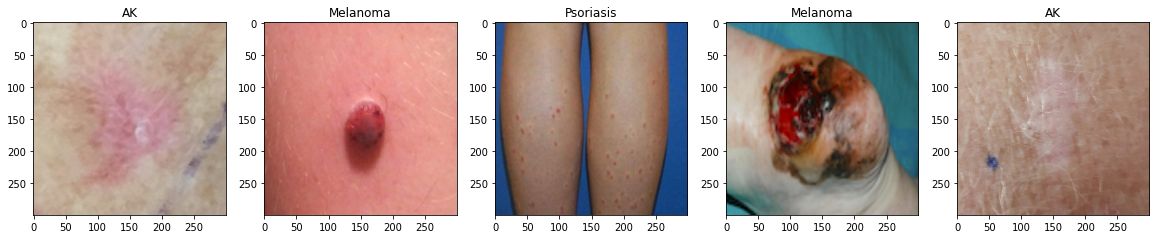

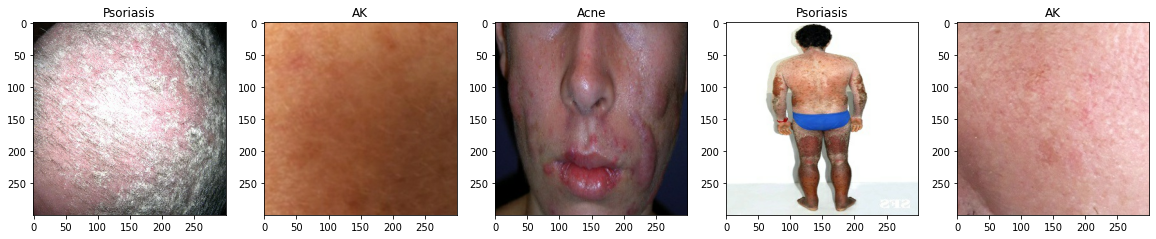

In [10]:
training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()
test_dataset = get_test_dataset()

# Training the Model

In [11]:
# instantiating the model in the strategy scope creates the model on the TPU
with strategy.scope():
    model = s(in_shape=(300, 300, 3),num_classes=4, conv_dropout_rate=0.5, dropout_rate=0.5,drop_connect=0.3)
    model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = model.fit(training_dataset,steps_per_epoch=STEPS_PER_EPOCH,validation_data=validation_dataset,epochs=EPOCHS,validation_steps=VAL_STEPS)

Epoch 1/40
116/116 [==============================] - 139s 332ms/step - loss: 1.4576 - accuracy: 0.3381 - val_loss: 1.4271 - val_accuracy: 0.2518
Epoch 2/40
116/116 [==============================] - 24s 209ms/step - loss: 1.2212 - accuracy: 0.4699 - val_loss: 1.5336 - val_accuracy: 0.2397
Epoch 3/40
116/116 [==============================] - 24s 208ms/step - loss: 1.1419 - accuracy: 0.5203 - val_loss: 1.6498 - val_accuracy: 0.2397
Epoch 4/40
116/116 [==============================] - 24s 208ms/step - loss: 1.0814 - accuracy: 0.5419 - val_loss: 1.9594 - val_accuracy: 0.2397
Epoch 5/40
116/116 [==============================] - 24s 209ms/step - loss: 1.0785 - accuracy: 0.5503 - val_loss: 2.5592 - val_accuracy: 0.2397
Epoch 6/40
116/116 [==============================] - 24s 209ms/step - loss: 1.0208 - accuracy: 0.5794 - val_loss: 1.3622 - val_accuracy: 0.4441
Epoch 7/40
116/116 [==============================] - 24s 209ms/step - loss: 0.9849 - accuracy: 0.5977 - val_loss: 1.3420 - val_a

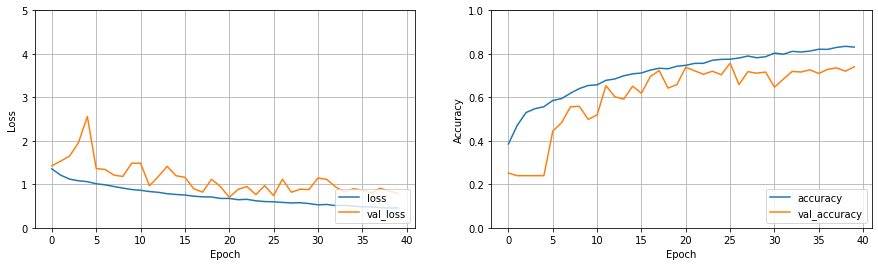

In [12]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.grid()
plt.legend(loc='lower right')
#plt.savefig('accuracy_curve_enetv2.png')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid()
plt.legend(loc='lower right')
plt.savefig('curves_enetv2_bs64.png')

In [13]:
import itertools
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('cf_enetv2_bs32.png')
    plt.show()

In [14]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, label: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
test_labels = []
for features in test_ds.unbatch().take(4000):
    test_labels.append(features[1].numpy())
test_predictions = list(predictions)

accuracy = sklearn.metrics.accuracy_score(test_labels, test_predictions)
print('Test accuracy:{}'.format(accuracy))


Computing predictions...


2022-04-24 21:12:43.552600: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 81458, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1650834763.552500200","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 81458, Output num: 0","grpc_status":3}


Test accuracy:0.7526595744680851


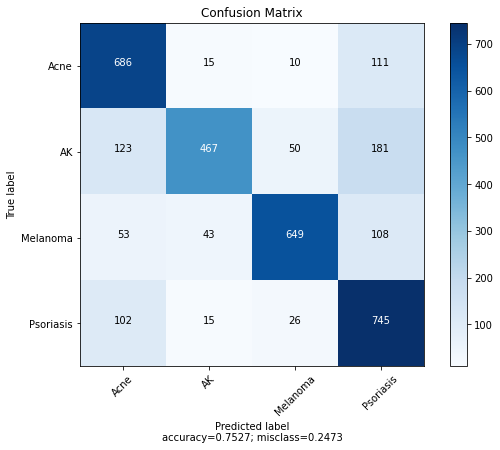

In [15]:
accuracy = sklearn.metrics.accuracy_score(test_labels, test_predictions)
cm = confusion_matrix(test_labels, test_predictions, labels=[0,1,2,3])
plot_confusion_matrix(cm = cm,normalize = False,target_names = ['Acne','AK','Melanoma','Psoriasis'],title = "Confusion Matrix")

In [16]:
import pickle

with open('./tfrec1trainHistory-goodcdr0.7', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [17]:
history = pickle.load(open('./tfrec1trainHistory-goodcdr0.7', "rb"))

In [18]:
class_names = ['Acne','Eczema','Melanoma','Psoriasis']
url = "https://images.prismic.io/npf-website/37fb7de7-c664-4112-8ae3-d26dcf6a75bb_plaque-psoriasis.jpg?auto=compress,format&rect=0,68,320,184&w=778&h=447"
path1 = tf.keras.utils.get_file('Red_sunflower', origin=url)

img1 = keras.preprocessing.image.load_img(
    path1, target_size=(300,300)
)
img_array = keras.preprocessing.image.img_to_array(img1)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(np.argmax(score), 100 * np.max(score))
)

57344/53834 [===============================] - 0s 0us/step
This image most likely belongs to 2 with a 47.54 percent confidence.
